In [330]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt


df1 = pd.read_csv('Data_Class_1.csv')
df2 = pd.read_csv('Data_Class_2.csv')
df3 = pd.read_csv('Data_Class_3.csv')

df = pd.concat([df1, df2, df3], axis=0)

df.reset_index(drop=True, inplace=True)


In [331]:
df.shape

(5184, 18)

In [332]:
# Generate descriptive statistics for the dataset
df.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level
count,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.00000,5184.000000,5184.000000
mean,7510.204861,2843.550926,161.878665,15.517554,256.798997,49.864198,2035.544367,209.343943,221.727238,142.834298,1708.383488,60.076663,299.36472,645.818277,34.885449
std,4624.413034,357.981922,111.928353,8.307825,199.066593,57.863126,1515.358119,31.160176,21.742296,41.390832,1248.504473,17.307780,87.00860,323.909683,17.445434
min,3.000000,1903.000000,0.000000,1.000000,0.000000,-146.000000,0.000000,58.000000,115.000000,0.000000,30.000000,30.000000,150.07000,90.070000,5.000000
25%,2978.500000,2561.750000,63.000000,9.000000,108.000000,9.000000,870.000000,194.750000,211.000000,117.000000,806.750000,45.125000,223.50750,357.600000,19.600000
50%,8273.500000,2935.000000,137.000000,14.000000,216.000000,34.000000,1572.500000,217.000000,225.000000,143.000000,1395.500000,60.160000,300.21500,645.960000,34.880000
75%,11262.250000,3136.250000,271.000000,21.000000,361.000000,75.000000,2916.250000,232.000000,237.000000,171.000000,2292.000000,75.115000,374.62250,933.370000,50.275000
max,15118.000000,3675.000000,360.000000,47.000000,1343.000000,547.000000,6836.000000,254.000000,254.000000,248.000000,6993.000000,89.980000,449.98000,1199.880000,64.990000


In [333]:
data_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Unique Values': df.nunique()
})

data_info

,Data Type,Missing Values,Unique Values
Id,int64,0,5184
Altitude,int64,0,1359
Slope_Orientation,int64,0,361
Slope,int64,0,46
Horizontal_Distance_To_Water,int64,0,290
Vertical_Distance_To_Water,int64,0,338
Horizontal_Distance_To_Roadways,int64,0,2346
Shadow_Index_9h,int64,0,170
Shadow_Index_12h,int64,0,127
Shadow_Index_15h,int64,0,232


Plot histograms for all numerical columns, to better understand their distributions.

Here we can see distribution of various numerical variables using histograms. Each plot visualizes how the data is spread for features such as Altitude, Slope Orientation, Slope, and more. The density curves (where applicable) help indicate the shape of these distributions. For instance, Altitude and Slope Orientation exhibit fairly normal distributions, while variables like Vertical Distance to Water show skewed distributions.



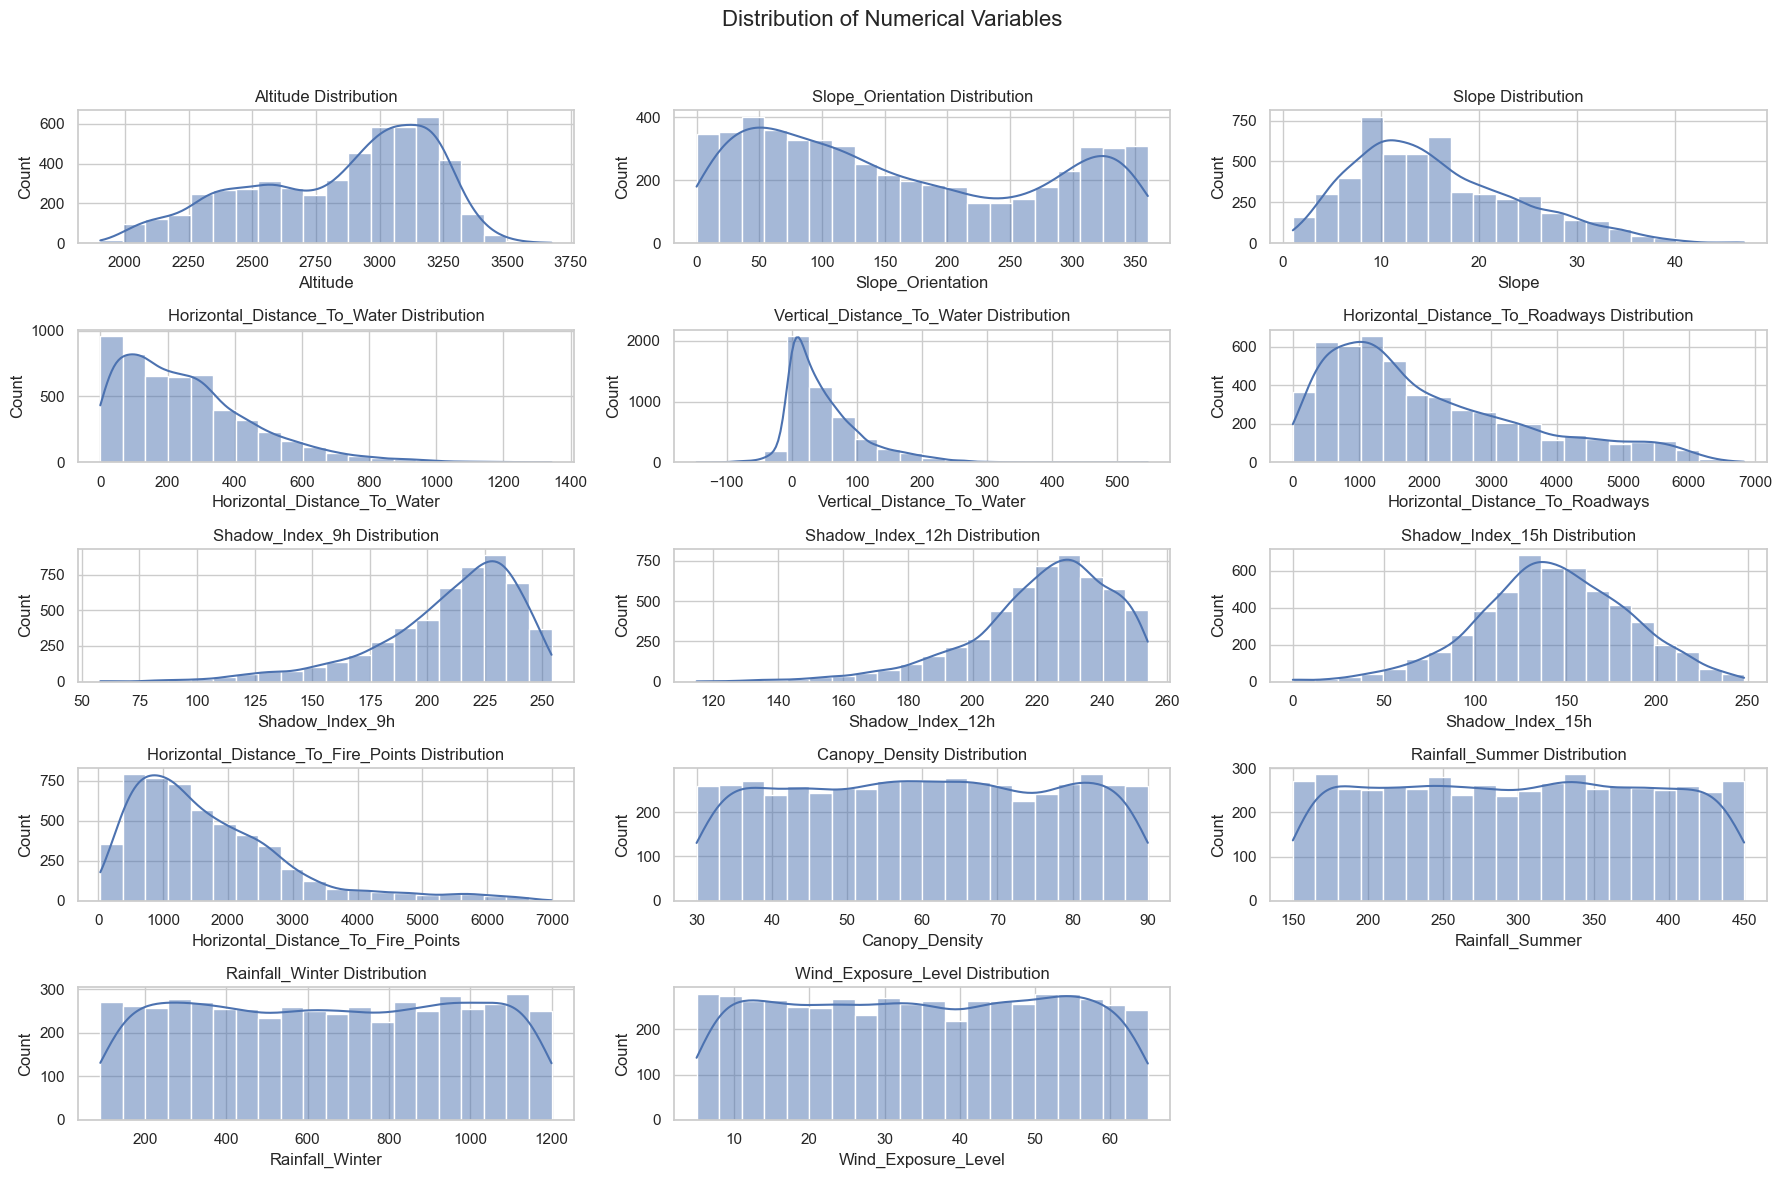

In [334]:

sns.set(style="whitegrid")

# List of numerical columns to plot
numerical_columns = [
    'Altitude', 'Slope_Orientation', 'Slope', 
    'Horizontal_Distance_To_Water', 'Vertical_Distance_To_Water', 
    'Horizontal_Distance_To_Roadways', 'Shadow_Index_9h', 
    'Shadow_Index_12h', 'Shadow_Index_15h', 
    'Horizontal_Distance_To_Fire_Points', 'Canopy_Density', 
    'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'
]

# Set up the subplots, adjusting number of rows and columns to fit all features
num_plots = len(numerical_columns)
cols = 3
rows = num_plots // cols + (num_plots % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
fig.suptitle('Distribution of Numerical Variables', fontsize=16)

# Plot histograms for each numerical feature
for i, col in enumerate(numerical_columns):
    row = i // cols
    col_idx = i % cols
    sns.histplot(df[col], kde=True, bins=20, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} Distribution')

# Hide any unused subplots
for i in range(num_plots, rows * cols):
    fig.delaxes(axes.flat[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Graphs for bivariate analysis, to see scatter plots between the numerical variables and target variable to observe any trends or patters.

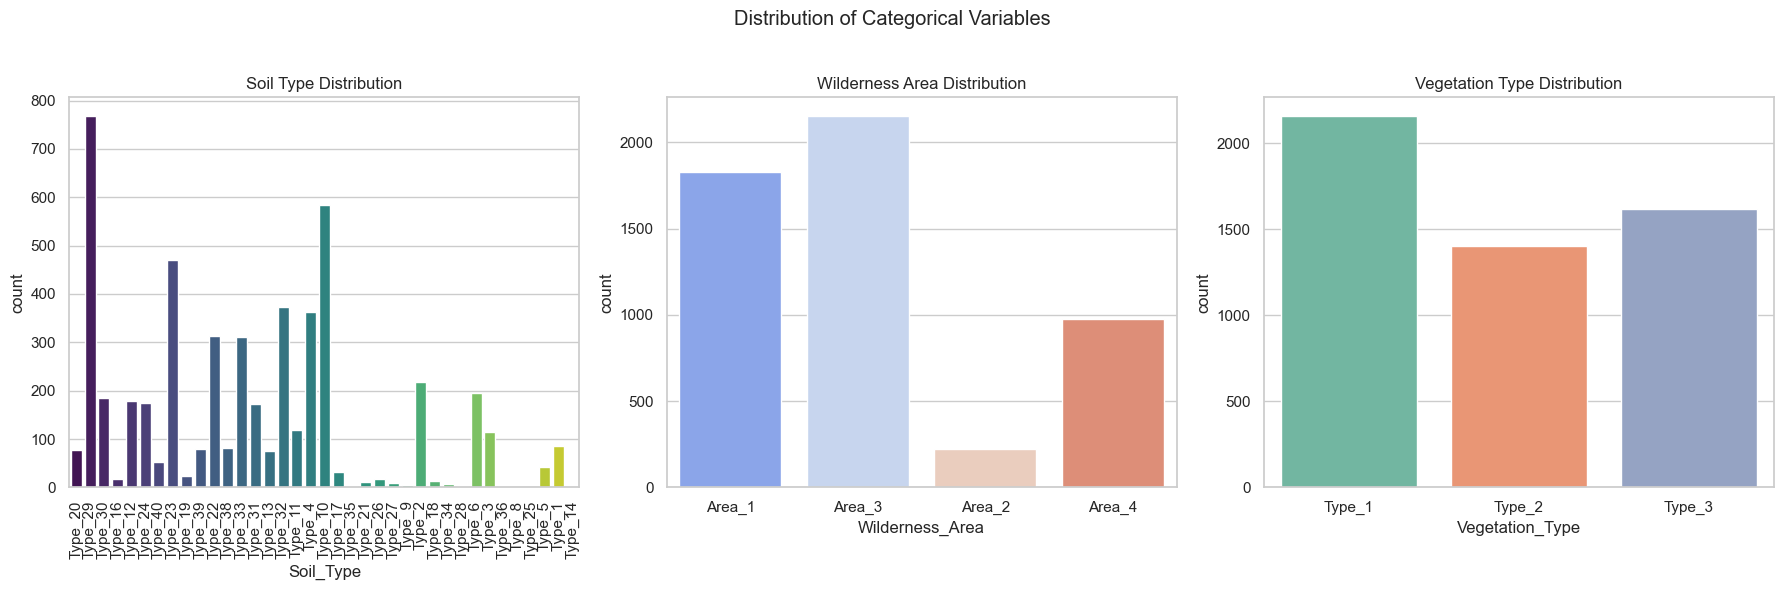

In [335]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the visualizations
sns.set(style="whitegrid")

# Plot bar plots for categorical variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribution of Categorical Variables')

# Plot for Soil_Type
sns.countplot(data=df, x='Soil_Type', hue='Soil_Type', ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Soil Type Distribution')
axes[0].tick_params(axis='x', rotation=90)  

# Plot for Wilderness_Area
sns.countplot(data=df, x='Wilderness_Area', hue='Wilderness_Area', ax=axes[1], palette='coolwarm', legend=False)
axes[1].set_title('Wilderness Area Distribution')

# Plot for Vegetation_Type
sns.countplot(data=df, x='Vegetation_Type', hue='Vegetation_Type', ax=axes[2], palette='Set2', legend=False)
axes[2].set_title('Vegetation Type Distribution')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# General Observations:
Altitude: The vegetation types appear to be well-separated by altitude. Type_1 is at a higher altitude, while Type_3 is at a lower altitude, with Type_2 in between. This suggests altitude may be a strong feature for distinguishing between the types.

Slope_Orientation: All three types show overlap in terms of slope orientation, so it doesn't seem to differentiate vegetation types strongly.

Slope: There is no significant distinction between the vegetation types based on slope alone, as all seem to occupy similar ranges.

Horizontal and Vertical Distance to Water: These variables show some degree of separation, especially for Type_3, which tends to have smaller horizontal distances to water. Type_1 and Type_2 overlap more but still show some separation.

Shadow Index (9h, 12h, 15h): There’s a fair amount of overlap in the shadow indices among the vegetation types, meaning these variables may not be significant in distinguishing between them.

Horizontal Distance to Roadways: This feature appears to be quite distinct, especially for Type_1, which has a wider range and larger distances from roadways compared to Type_2 and Type_3.

Horizontal Distance to Fire Points: This variable has some separation between vegetation types, with Type_1 having much higher distances to fire points than Type_2 and Type_3, which cluster lower on this axis.

Canopy Density: All vegetation types appear to have similar canopy densities, making it difficult to differentiate between them based on this feature.

Rainfall (Summer and Winter): The rainfall in both seasons seems to be very similar across vegetation types, showing little to no variation or overlap.

Wind Exposure Level: There is minimal distinction among the vegetation types based on wind exposure, as all appear to have similar values.

## Key Insights:
Altitude and horizontal distance to roadways/fire points appear to be strong variables for separating vegetation types, particularly Type_1.
Some features, like slope orientation, shadow indices, and canopy density, show a lot of overlap, suggesting they might not be as important in classification.
Horizontal distance to water also provides some separability for Type_3, which might help in classification.

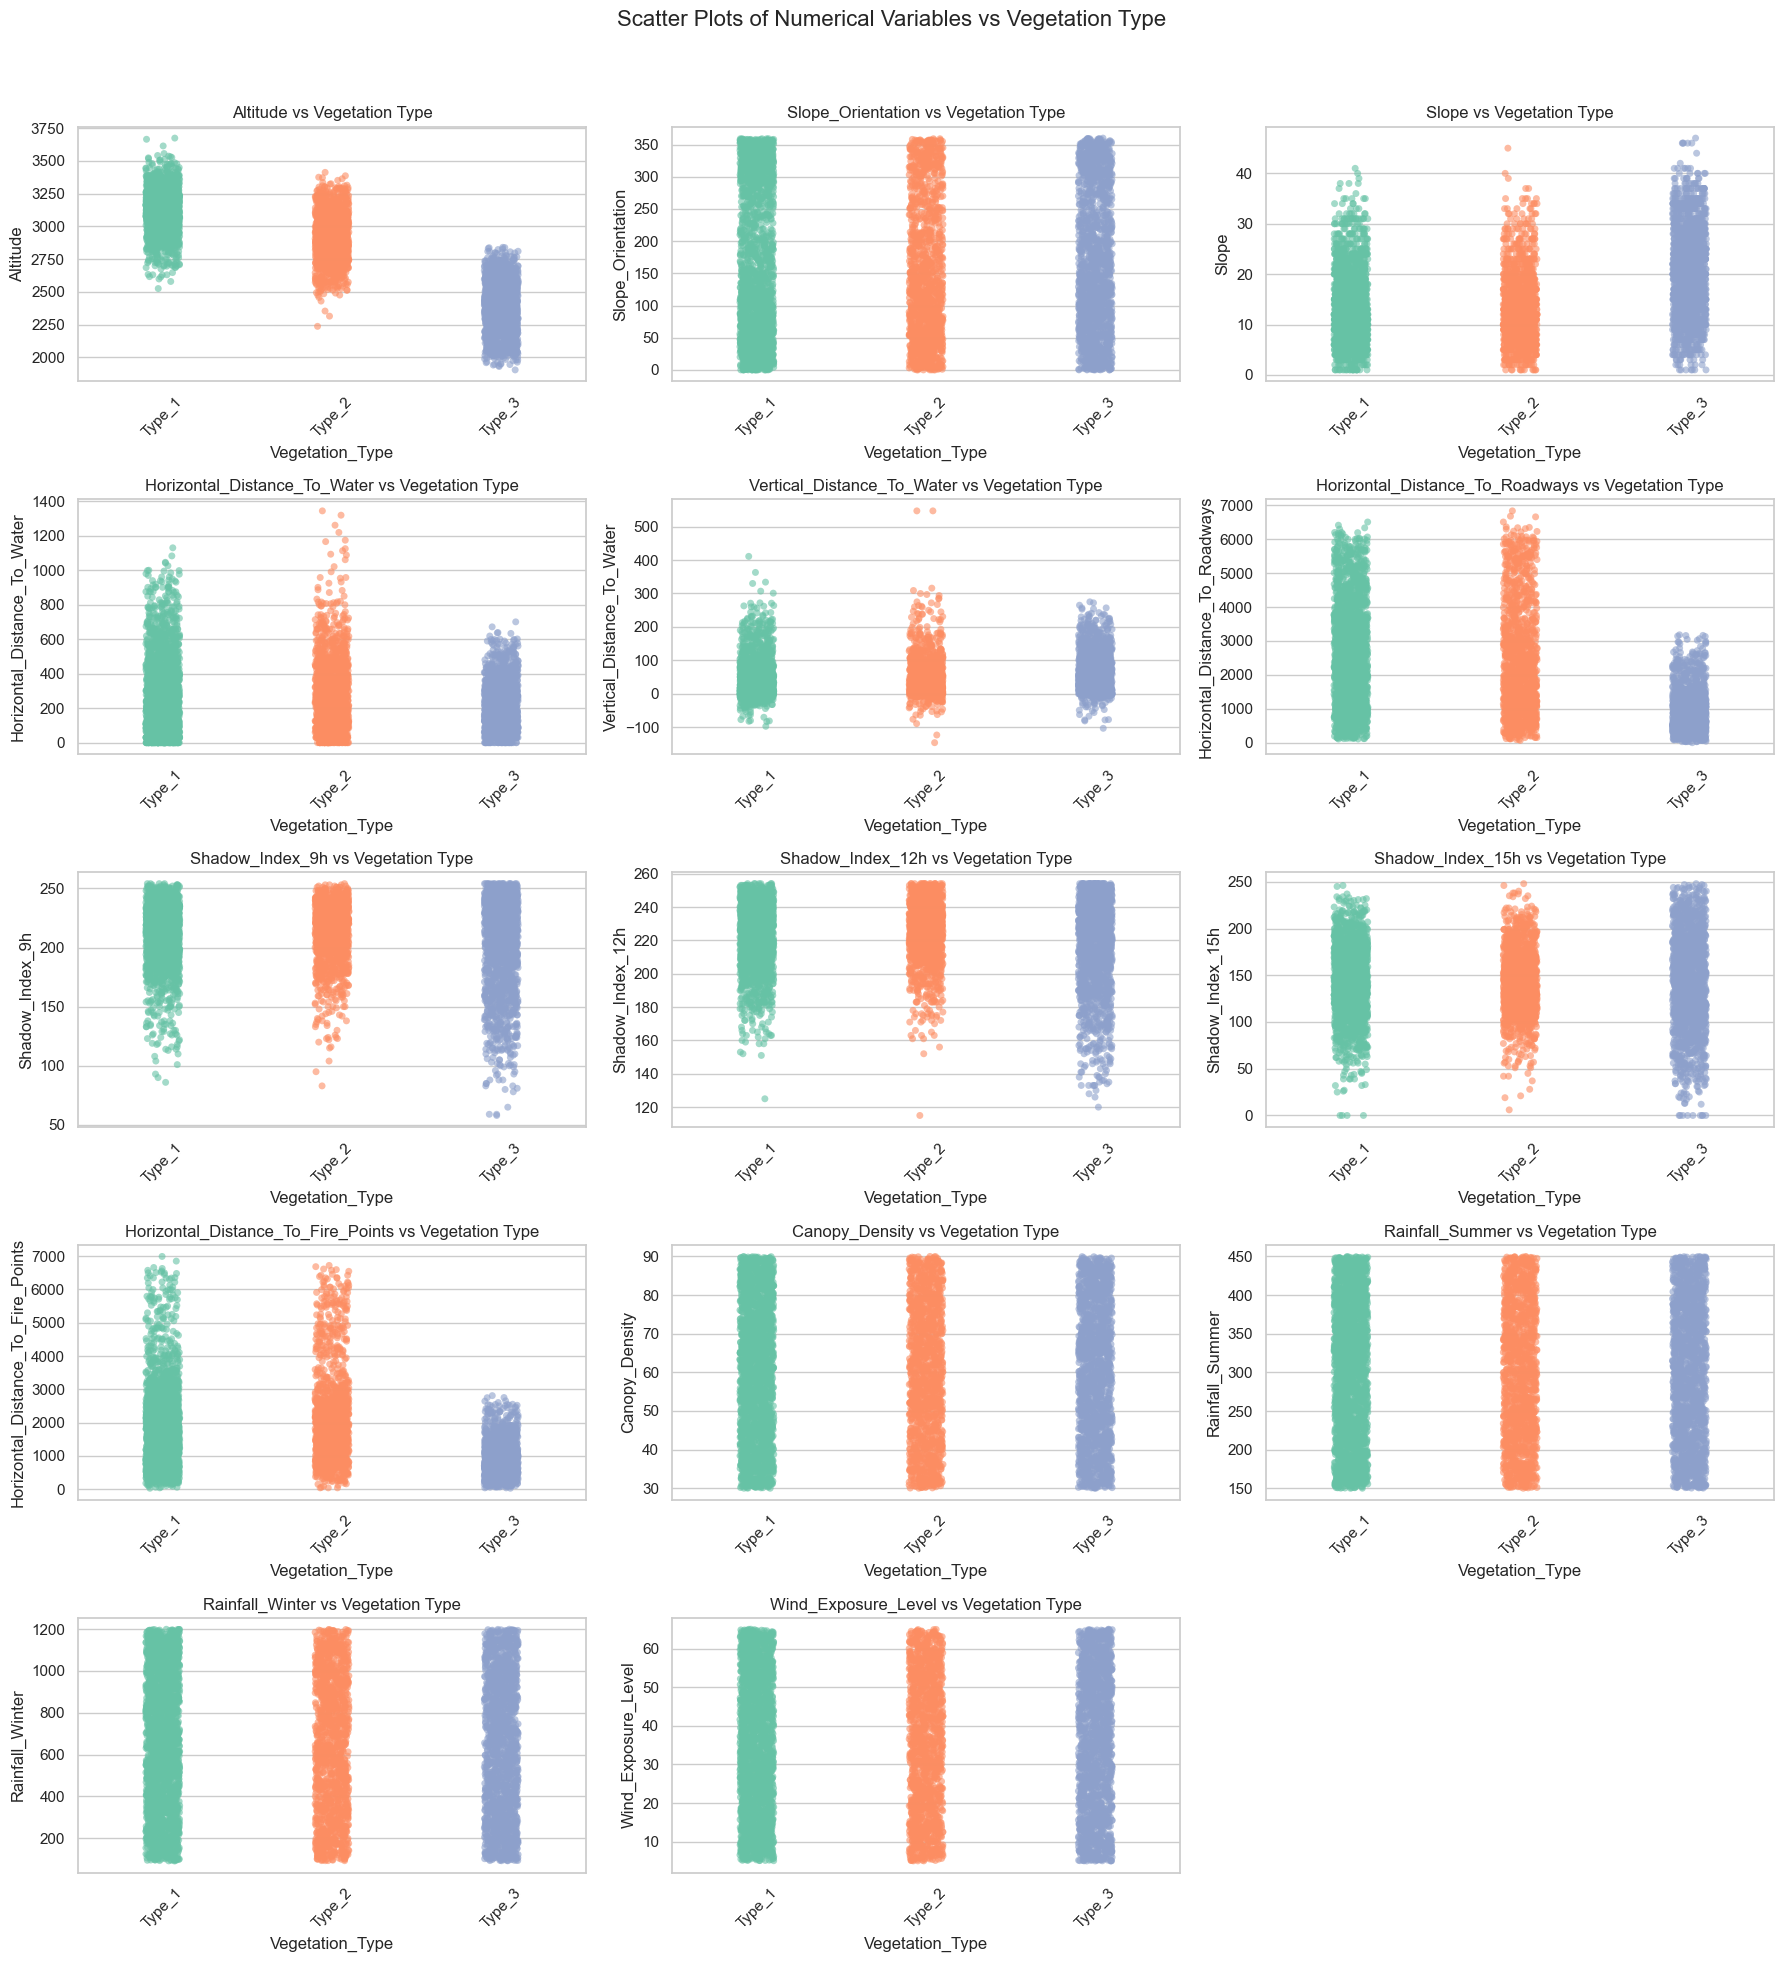

In [336]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the visualizations
sns.set(style="whitegrid")

# List of numerical variables to plot against Vegetation_Type
numerical_columns = [
    'Altitude', 'Slope_Orientation', 'Slope', 
    'Horizontal_Distance_To_Water', 'Vertical_Distance_To_Water', 
    'Horizontal_Distance_To_Roadways', 'Shadow_Index_9h', 
    'Shadow_Index_12h', 'Shadow_Index_15h', 
    'Horizontal_Distance_To_Fire_Points', 'Canopy_Density', 
    'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'
]

# Set up the subplots grid
num_plots = len(numerical_columns)
cols = 3  # Number of columns
rows = num_plots // cols + (num_plots % cols > 0)  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
fig.suptitle('Scatter Plots of Numerical Variables vs Vegetation Type', fontsize=16)

# Plot each numerical variable vs Vegetation_Type
for i, col in enumerate(numerical_columns):
    row = i // cols
    col_idx = i % cols
    # Use stripplot for jitter effect or scatterplot directly
    sns.stripplot(x='Vegetation_Type', y=col, data=df, ax=axes[row, col_idx], jitter=True, palette='Set2', hue='Vegetation_Type', alpha=0.6, legend=False)
    axes[row, col_idx].set_title(f'{col} vs Vegetation Type')
    axes[row, col_idx].tick_params(axis='x', rotation=45)  # Rotate x labels for readability

# Hide any empty subplots (if any)
for i in range(num_plots, rows * cols):
    fig.delaxes(axes.flat[i])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


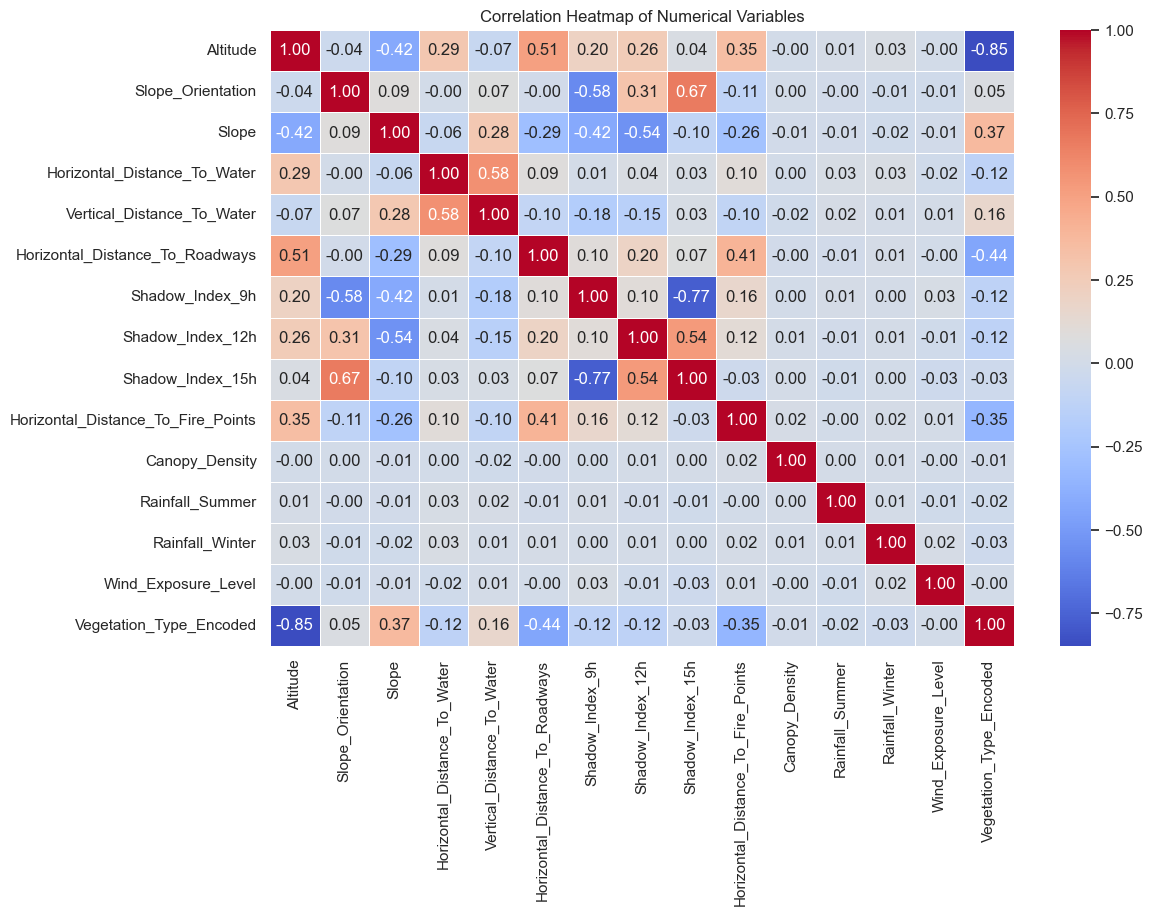

In [337]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Convert Vegetation_Type to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
df['Vegetation_Type_Encoded'] = label_encoder.fit_transform(df['Vegetation_Type'])

# List of numerical columns to include in the correlation heatmap
numerical_columns = [
    'Altitude', 'Slope_Orientation', 'Slope', 
    'Horizontal_Distance_To_Water', 'Vertical_Distance_To_Water', 
    'Horizontal_Distance_To_Roadways', 'Shadow_Index_9h', 
    'Shadow_Index_12h', 'Shadow_Index_15h', 
    'Horizontal_Distance_To_Fire_Points', 'Canopy_Density', 
    'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level',
    'Vegetation_Type_Encoded'  # Include encoded Vegetation_Type
]

# Compute the correlation matrix
corr_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


Box plots for comparing categorical variables.

In the graphs, we observe the relationship between Soil Type and Vegetation Type. The first two vegetation types (Type 1 and Type 2) show similar distributions for the various soil types. However, Vegetation Type 3 exhibits a distinct soil type distribution, indicating that it occurs in areas with different soil characteristics.

For the Wilderness Area vs Vegetation Type plot, we see that Vegetation Types 1 and 2 share similar wilderness areas (Areas 1, 2, and 3). In contrast, Vegetation Type 3 appears to be predominantly associated with Area 4, suggesting a different wilderness distribution compared to the other vegetation types.

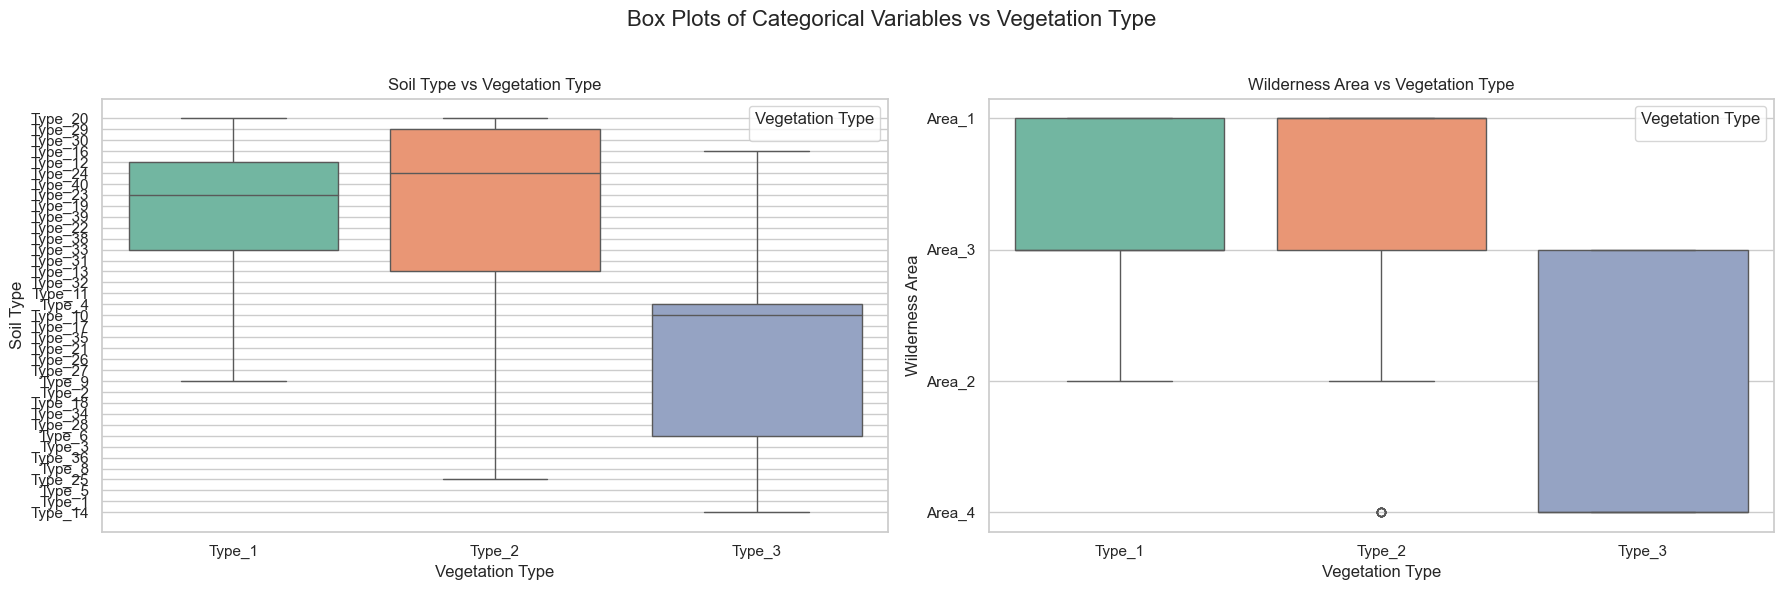

In [338]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the visualizations
sns.set(style="whitegrid")

# Plot box plots for categorical variables vs Vegetation_Type
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Box Plots of Categorical Variables vs Vegetation Type', fontsize=16)

# Box plot for Soil_Type vs Vegetation_Type
sns.boxplot(x='Vegetation_Type', y='Soil_Type', data=df, ax=axes[0], palette='Set2', hue='Vegetation_Type', legend=False)
axes[0].set_title('Soil Type vs Vegetation Type')
axes[0].set_xlabel('Vegetation Type')
axes[0].set_ylabel('Soil Type')

# Box plot for Wilderness_Area vs Vegetation_Type
sns.boxplot(x='Vegetation_Type', y='Wilderness_Area', data=df, ax=axes[1], palette='Set2', hue='Vegetation_Type', legend=False)
axes[1].set_title('Wilderness Area vs Vegetation Type')
axes[1].set_xlabel('Vegetation Type')
axes[1].set_ylabel('Wilderness Area')

# Remove automatic legends
axes[0].legend([], [], title='Vegetation Type', loc='upper right')
axes[1].legend([], [], title='Vegetation Type', loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Tryout LR all variables
The model demonstrates good predictive ability with an accuracy of up to 84.6%. However, performance is weaker for Type_2 vegetation, which suggests room for improvement in capturing this class. Further efforts can be made to balance the model's performance across all vegetation types.

Accuracy: 0.8360655737704918
Confusion Matrix:
[[376  66   1]
 [ 74 169  24]
 [  0   5 322]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.84      0.85      0.84       443
      Type_2       0.70      0.63      0.67       267
      Type_3       0.93      0.98      0.96       327

    accuracy                           0.84      1037
   macro avg       0.82      0.82      0.82      1037
weighted avg       0.83      0.84      0.83      1037



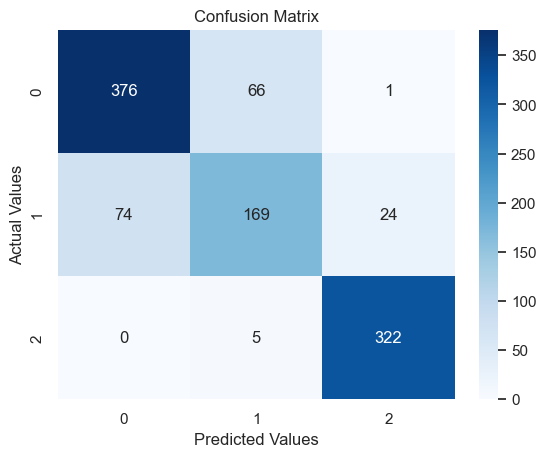

In [339]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load your dataset (adjust the file path as needed)
# Assuming df is already loaded with the Vegetation_Type and Vegetation_Type_Encoded

# Step 3: Prepare the data
# Define numerical features
numerical_features = [ 
    'Altitude', 'Slope_Orientation', 'Slope', 
    'Horizontal_Distance_To_Water', 'Vertical_Distance_To_Water', 
    'Horizontal_Distance_To_Roadways', 'Shadow_Index_9h', 
    'Shadow_Index_12h', 'Shadow_Index_15h', 
    'Horizontal_Distance_To_Fire_Points', 'Canopy_Density'
    ,'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'
]

y = df['Vegetation_Type']


# Define categorical features
categorical_features = ['Soil_Type', 'Wilderness_Area']  # Add your categorical columns here

dummies = pd.get_dummies(df[categorical_features])
dummies.head()
x_numerical = df[numerical_features]

# Convert categorical variables into dummy variables
X = pd.concat([dummies, x_numerical], axis=1)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature Scaling (Standardize the data)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Apply Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = logreg.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 9: Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


Accuracy: 0.845708775313404
Confusion Matrix:
[[384  56   3]
 [ 76 168  23]
 [  0   2 325]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.83      0.87      0.85       443
      Type_2       0.74      0.63      0.68       267
      Type_3       0.93      0.99      0.96       327

    accuracy                           0.85      1037
   macro avg       0.83      0.83      0.83      1037
weighted avg       0.84      0.85      0.84      1037



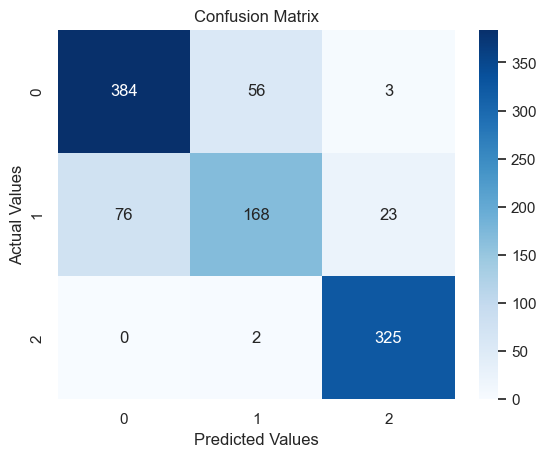

In [340]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load your dataset (adjust the file path as needed)
# Assuming df is already loaded with the Vegetation_Type and Vegetation_Type_Encoded

# Step 3: Prepare the data
# Separate target variable (Vegetation_Type) and features
y = df['Vegetation_Type']

# Define numerical and categorical features
numerical_features = ['Altitude', 'Slope_Orientation', 'Horizontal_Distance_To_Roadways',
                      'Shadow_Index_9h', 'Shadow_Index_12h', 
                      
                      #, 'Shadow_Index_15h',
                      #'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'
                      ]

categorical_features = ['Soil_Type', 'Wilderness_Area']  # Include your categorical columns

# Convert categorical variables into dummy variables
X_categorical = pd.get_dummies(df[categorical_features], drop_first=True)

# Keep numerical variables as is
X_numerical = df[numerical_features]

# Combine numerical and dummy categorical variables
X = pd.concat([X_numerical, X_categorical], axis=1)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 5: Feature Scaling (Standardize the data)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Apply Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = logreg.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 9: Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


Accuracy: 0.8360655737704918
Confusion Matrix:
[[375  62   6]
 [ 72 167  28]
 [  0   2 325]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.84      0.85      0.84       443
      Type_2       0.72      0.63      0.67       267
      Type_3       0.91      0.99      0.95       327

    accuracy                           0.84      1037
   macro avg       0.82      0.82      0.82      1037
weighted avg       0.83      0.84      0.83      1037



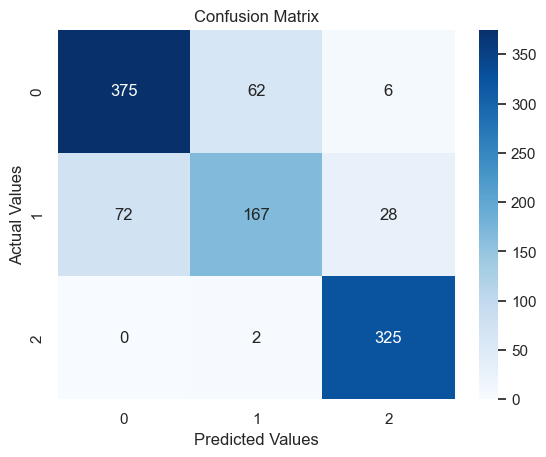

In [341]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y = df['Vegetation_Type']

# Define numerical and categorical features
numerical_features = ['Altitude', 'Slope_Orientation', 'Horizontal_Distance_To_Roadways',
                      'Shadow_Index_9h', 'Shadow_Index_12h']

categorical_features = ['Soil_Type', 'Wilderness_Area']  # Include your categorical columns

# Step 3: Convert categorical variables into dummy variables
# It's important to include only the selected features after converting to dummy
X_categorical = pd.get_dummies(df[categorical_features], drop_first=True)

# Keep numerical variables as is
X_numerical = df[numerical_features]

# Combine numerical and dummy categorical variables
X = pd.concat([X_numerical, X_categorical], axis=1)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature Scaling (Standardize the data)
scaler = MinMaxScaler()  # Create a StandardScaler object
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)  # Only transform the test data

# Step 6: Apply Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Step 7: Make predictions on the test data
y_pred = lda.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 9: Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


Accuracy: 0.7020250723240116
Confusion Matrix:
[[394   1  48]
 [192   7  68]
 [  0   0 327]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.67      0.89      0.77       443
      Type_2       0.88      0.03      0.05       267
      Type_3       0.74      1.00      0.85       327

    accuracy                           0.70      1037
   macro avg       0.76      0.64      0.56      1037
weighted avg       0.75      0.70      0.61      1037



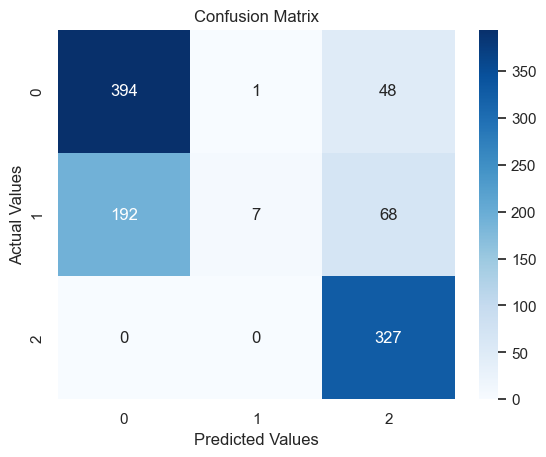

In [342]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis  # Import QDA instead of LDA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already defined and loaded with your dataset
y = df['Vegetation_Type']

# Define numerical and categorical features
numerical_features = ['Altitude', 'Slope_Orientation', 'Horizontal_Distance_To_Roadways',
                      'Shadow_Index_9h', 'Shadow_Index_12h']

categorical_features = ['Soil_Type', 'Wilderness_Area']  # Include your categorical columns

# Step 3: Convert categorical variables into dummy variables
# It's important to include only the selected features after converting to dummy
X_categorical = pd.get_dummies(df[categorical_features], drop_first=True)

# Keep numerical variables as is
X_numerical = df[numerical_features]

# Combine numerical and dummy categorical variables
X = pd.concat([X_numerical, X_categorical], axis=1)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Feature Scaling (Standardize the data)
scaler = MinMaxScaler()  # Create a MinMaxScaler object
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_test = scaler.transform(X_test)  # Only transform the test data

# Step 6: Apply Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()  # Create a QDA object
qda.fit(X_train, y_train)  # Fit the QDA model to the training data

# Step 7: Make predictions on the test data
y_pred = qda.predict(X_test)

# Step 8: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Step 9: Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


## Preparing data for models

In [343]:
def preprocess_data(df, target, numerical_features, categorical_features):
    # Combine numerical and categorical features
    selected_features = numerical_features + categorical_features
    
    # Separate features and target variable
    X = df[selected_features]
    y = df[target]
    
    # Convert categorical variables into dummy variables
    X = pd.get_dummies(X, drop_first=True)
    
    # Scale numerical features
    scaler = MinMaxScaler()
    X[numerical_features] = scaler.fit_transform(X[numerical_features])

    return X, y

## Holdout validation

In [344]:
def holdout_validation(model, X, y, test_size=0.2):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f"Holdout Validation Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    # Plot confusion matrix
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    # plt.title('Confusion Matrix (Holdout Validation)')
    # plt.ylabel('Actual Values')
    # plt.xlabel('Predicted Values')
    # plt.show()

## Cross validation

In [345]:
def k_fold_cross_validation(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"K-Fold Cross Validation (k={k}) Accuracy Scores: {scores}")
    print(f"Mean Accuracy: {np.mean(scores)}")

## LOOCV Cross validation

In [346]:
def loocv_cross_validation(model, X, y, max_samples=None):
    loo = LeaveOneOut()
    
    # Use max_samples to limit the number of LOOCV evaluations
    if max_samples is not None and max_samples < len(X):
        indices = np.random.choice(len(X), max_samples, replace=False)
        X = X.iloc[indices]
        y = y.iloc[indices]

    accuracies = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    print(f"LOOCV Accuracy: {np.mean(accuracies):.4f}")

## Bootstrap evaluation

In [347]:
def bootstrap_evaluation(model, X, y, n_iterations=1000):
    n_size = int(len(X) * 0.9)  # Use 90% of the data for bootstrap sample
    scores = []

    for i in range(n_iterations):
        # Generate a bootstrap sample
        X_train, y_train = resample(X, y, n_samples=n_size, random_state=i)
        
        # Fit the model on the bootstrap sample
        model.fit(X_train, y_train)
        
        # Test on the out-of-bag data (remaining 10%)
        X_test, y_test = X.drop(X_train.index), y.drop(y_train.index)
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        scores.append(accuracy)

    print(f"Bootstrap Mean Accuracy: {np.mean(scores)}")
    print(f"Bootstrap Standard Deviation: {np.std(scores)}")

## Pipeline for running resempling in models

In [348]:
def run_cross_validation_pipeline(df, model, target='Vegetation_Type', use_loocv=False, use_bootstrap=False):
    # Define numerical and categorical features
    numerical_features = ['Altitude', 'Slope_Orientation', 'Horizontal_Distance_To_Roadways', 
                          'Shadow_Index_9h', 'Shadow_Index_12h']
    categorical_features = ['Soil_Type', 'Wilderness_Area']
    
    # Step 1: Preprocess the data
    X, y = preprocess_data(df, target, numerical_features, categorical_features)

    
    # Step 2: Perform Holdout Validation
    print("Holdout Validation Results:")
    holdout_validation(model, X, y, test_size=0.2)
    
    # Step 3: Perform K-Fold Cross Validation
    print("\nK-Fold Cross Validation Results (k=5):")
    k_fold_cross_validation(model, X, y, k=5)
    
    print("\nK-Fold Cross Validation Results (k=10):")
    k_fold_cross_validation(model, X, y, k=10)
    
    # Step 4: Optionally Perform Leave-One-Out Cross Validation (LOOCV)
    if use_loocv:
        print("\nLOOCV Results:")
        loocv_cross_validation(model, X, y, max_samples=1000)
    
    # Step 5: Optionally Perform Bootstrap Evaluation
    if use_bootstrap:
        print("\nBootstrap Evaluation Results:")
        bootstrap_evaluation(model, X, y, n_iterations=1000)  # Limit Bootstrap iterations


### Trying the types

In [349]:
logreg_model = LogisticRegression()
lda_model = LinearDiscriminantAnalysis()
qda_model = QuadraticDiscriminantAnalysis()
# Example usage without LOOCV and Bootstrap (default)
#run_cross_validation_pipeline(df, logreg_model)

# Example usage with LOOCV and Bootstrap (optional)
run_cross_validation_pipeline(df, logreg_model, use_loocv=True, use_bootstrap=True)

# run_cross_validation_pipeline(df, lda_model, use_loocv=True, use_bootstrap=True)

# run_cross_validation_pipeline(df, qda_model, use_loocv=True, use_bootstrap=True)




Holdout Validation Results:
Holdout Validation Accuracy: 0.845708775313404
Confusion Matrix:
[[384  56   3]
 [ 76 168  23]
 [  0   2 325]]
Classification Report:
              precision    recall  f1-score   support

      Type_1       0.83      0.87      0.85       443
      Type_2       0.74      0.63      0.68       267
      Type_3       0.93      0.99      0.96       327

    accuracy                           0.85      1037
   macro avg       0.83      0.83      0.83      1037
weighted avg       0.84      0.85      0.84      1037


K-Fold Cross Validation Results (k=5):
K-Fold Cross Validation (k=5) Accuracy Scores: [0.84570878 0.81388621 0.82545805 0.82545805 0.81467181]
Mean Accuracy: 0.8250365808707179

K-Fold Cross Validation Results (k=10):
K-Fold Cross Validation (k=10) Accuracy Scores: [0.83236994 0.85549133 0.8150289  0.79961464 0.82625483 0.84362934
 0.83783784 0.81467181 0.81467181 0.81467181]
Mean Accuracy: 0.8254242268693137

LOOCV Results:
LOOCV Accuracy: 0.7860

Boo

In [350]:
from sklearn.metrics import accuracy_score, f1_score

def compare_models(models, X_train, X_test, y_train, y_test):
    comparison_results = []
    
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        comparison_results.append({'Model': name, 'Accuracy': accuracy, 'F1 Score': f1})

    return pd.DataFrame(comparison_results)

# Example usage
models = [('Logistic Regression', logreg_model), ('LDA', lda_model), ('QDA', qda_model)]
compare_models(models, X_train, X_test, y_train, y_test)


,Model,Accuracy,F1 Score
0,Logistic Regression,0.845709,0.841117
1,LDA,0.836066,0.831462
2,QDA,0.702025,0.608077


# Feature Selection

There are two major problems related to training models: **overfitting** and **underfitting**:

- Overfitting: The model performs well on the training set but not so well on unseen (test) data.
- Underfitting: Neither performs well on the train set nor on the test set.

**Regularization** is implemented to avoid overfitting of the data, especially when there is a large variance between train and test set
performances. There are different methods of reducing the model complexity and preventing overfitting in linear models which are *Ridge* and *Lasso*
*Regression Models*.

## Preparing Data for Ridge Regression

Before applying Ridge Regression, we need to properly prepare the dataset. This involves several steps, such as:

1. **Feature Selection/Engineering**: Ensure relevant features are selected and encoded.
2. **Splitting the Data**: Divide the dataset into training and test sets.
3. **Feature Scaling**: Apply scaling to ensure features are on a similar scale, as Ridge Regression is sensitive to feature magnitudes.

Below is an example of how to prepare data for Ridge Regression.


In [351]:
# Import all libraries 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.metrics import mean_squared_error , root_mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler 
import numpy as np  
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

df.head(5)

def prepare_dataset(df, target, categorical_features, numerical_features, numberical_target_var = True):

    df.isnull().sum()*100/df.shape[0]
    df.head()
    # Encode the target variable if it's categorical
    if numberical_target_var == False:
        le = LabelEncoder()
        y = le.fit_transform(df[target])
    
    # Convert the categorical columns into the boolean type, remove the Id col
    dummies = pd.get_dummies(df[categorical_features])

    # Drop the categorical features from the X
    X_ = df.drop(categorical_features, axis = 1) 
    # Drop the target variable
    X_ = X_.drop(target, axis = 1) 
    X_ = X_.drop(["Id"], axis=1) # TODO remove

    # Convert all numerical values to the float type
    X = X_.apply(lambda col: col.astype('float64') if col.dtype in ['int64', 'float32', 'float64'] else col)
    # Merge the dummies (categorical var w numerical variables)
    X = pd.concat([X, dummies], axis = 1) 

    return X, y


In [352]:
# Display the head of the dataset before any modification
df = df.drop("Vegetation_Type_Encoded", axis=1)
df.head(5)


,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type,Wilderness_Area,Vegetation_Type
0,41,2699,347,3,0,0,2096,213,234,159,6853,37.32,282.46,125.22,6.23,Type_20,Area_1,Type_1
1,52,2739,323,25,85,43,3118,149,205,192,6219,76.51,182.57,532.19,30.65,Type_29,Area_1,Type_1
2,53,2696,72,2,30,0,3271,222,234,149,6071,86.37,374.79,275.52,59.96,Type_30,Area_1,Type_1
3,56,2722,315,24,30,19,3216,148,212,200,6132,85.31,364.30,1182.48,22.21,Type_16,Area_1,Type_1
4,68,2919,13,13,90,6,5321,207,214,142,4060,78.13,303.26,1198.69,14.22,Type_29,Area_1,Type_1


In [353]:
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables 
y = df.Vegetation_Type
le = LabelEncoder()
y = le.fit_transform(y)

numerical_features = ["Altitude", "Slope_Orientation", "Slope", "Horizontal_Distance_To_Water"
    ,"Vertical_Distance_To_Water", "Horizontal_Distance_To_Roadways", "Shadow_Index_9h",
    "Shadow_Index_12h", "Shadow_Index_15h", "Horizontal_Distance_To_Fire_Points", 
    "Canopy_Density", "Rainfall_Summer", "Rainfall_Winter", "Wind_Exposure_Level"]
categorical_features = ["Wilderness_Area", "Soil_Type"]
target_variable = "Vegetation_Type"

# Get x,y data
X, y = prepare_dataset(df, target_variable, categorical_features, numerical_features, False)
# Show info about X data
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Altitude                            5184 non-null   float64
 1   Slope_Orientation                   5184 non-null   float64
 2   Slope                               5184 non-null   float64
 3   Horizontal_Distance_To_Water        5184 non-null   float64
 4   Vertical_Distance_To_Water          5184 non-null   float64
 5   Horizontal_Distance_To_Roadways     5184 non-null   float64
 6   Shadow_Index_9h                     5184 non-null   float64
 7   Shadow_Index_12h                    5184 non-null   float64
 8   Shadow_Index_15h                    5184 non-null   float64
 9   Horizontal_Distance_To_Fire_Points  5184 non-null   float64
 10  Canopy_Density                      5184 non-null   float64
 11  Rainfall_Summer                     5184 no

In [354]:
# Show head of the X data
X.head(5)

,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,...,Soil_Type_Type_35,Soil_Type_Type_36,Soil_Type_Type_38,Soil_Type_Type_39,Soil_Type_Type_4,Soil_Type_Type_40,Soil_Type_Type_5,Soil_Type_Type_6,Soil_Type_Type_8,Soil_Type_Type_9
0,2699.0,347.0,3.0,0.0,0.0,2096.0,213.0,234.0,159.0,6853.0,...,False,False,False,False,False,False,False,False,False,False
1,2739.0,323.0,25.0,85.0,43.0,3118.0,149.0,205.0,192.0,6219.0,...,False,False,False,False,False,False,False,False,False,False
2,2696.0,72.0,2.0,30.0,0.0,3271.0,222.0,234.0,149.0,6071.0,...,False,False,False,False,False,False,False,False,False,False
3,2722.0,315.0,24.0,30.0,19.0,3216.0,148.0,212.0,200.0,6132.0,...,False,False,False,False,False,False,False,False,False,False
4,2919.0,13.0,13.0,90.0,6.0,5321.0,207.0,214.0,142.0,4060.0,...,False,False,False,False,False,False,False,False,False,False


In [355]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.5, random_state=42)
sc=StandardScaler() 
X_train=sc.fit_transform(X_train) 
X_test=sc.transform(X_test)

#from sklearn.preprocessing import minmax_scale 
# minmax_scale = MinMaxScaler()
# X_train=minmax_scale(X_train, axis=0) 
# X_test=sc.transform(X_test) 

In [356]:
# Generate an NumPy array of alphas from small to large 
# number which are logarithmically spaced, meaning they decrease exponentially

alphas = 10**np.linspace(10,-2,100)*0.5 

# Uncomment the alphas if you want to see the array
# alphas 

## Ridge Resgression
Is a variation of linear regression, specifically designed to address multicollinearity in the dataset. In linear regression, the goal is to find the best-fitting hyperplane that minimizes the sum of squared differences between the
observed and predicted values, but when there is high correlation between variables, LR model may be moderately or highly correlated with another.
Multicollinearity exists when 2 or more predictors in regression model are correlated with another one. 

**Ridge Regression** use *L2 penalty*, that penalize the large coefficients to prevent overfitting.

The tuning parameter λ serves to control the relative impact, when λ = 0 than penalty has no effect. As λ grows to infitite the penalty grows which lead to shrinking coeffiecients to zero. Cross-Validation is used for selecting a good value for λ as it's very important.

In [357]:
"""
In this cell we perform Ridge Regression for multiple alpha values that were 
generated in the cell before and calculate the coefficients, MSE, Bias and Variance for each model.
Data are then used for plots.
"""

ridge = Ridge() 
coefs = [] 

mse = []
squared_bias = []
variance = []
 
for a in alphas: 
    ridge.set_params(alpha = a) 
    ridge.fit(X, y) 
    coefs.append(ridge.coef_) 
    y_pred = ridge.predict(X_test)

     # Calculate MSE
    mse.append(np.mean((y_pred - y_test) ** 2))
    
    # Calculate bias and variance
    bias = np.mean(y_pred - y_test)
    squared_bias.append(bias ** 2)
    variance.append(np.var(y_pred))
     
np.shape(coefs)


(100, 55)

### Plot description
#### Plot axis
This snippet of code visualizes how the coefficients (weights) of a Ridge Regression model change across different values of the regularization parameter, alpha. 
- X-axis: 
    - This is the regularization parameter for Ridge Regression.
    - Smaller alpha values mean less regularization 
    - Larger alpha values mean more regularization, which shrinks the coefficients towards zero.
- Y-axis
    - Each line corresponds to the coefficient value (weight) of a feature in the model.

### Plot behaviour
- Small alpha values
    - Coefficients are large (the model tries to fit the training data closely).
- As alpha increases
    - Coefficients shrink towards zero, indicating regularization
    - If coefficient shrink to exactly 0 that mean feature is ignored in model
- Very high alpha
    - All coefficients tend towards zero, and the model behaves like a simple mean-based model 

### Key sights
- Lower alpha indicate more complex model but potentially overfitting
- Higher alpha stabilize coefficients or shrink to zero, indicating simpler/more stable model but may underfit data
- If coefficients drop to zero early, that suggest that feature **may not cotribute to much** in model

Text(0, 0.5, 'weights')

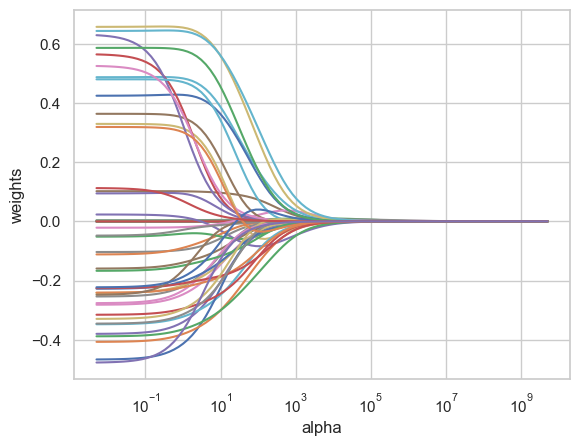

In [358]:
ax = plt.gca() 
ax.plot(alphas, coefs) 
ax.set_xscale('log') 
plt.axis('tight') 
plt.xlabel('alpha') 
plt.ylabel('weights')

The Ridge Regression Bias-Variance Tradeoff graph helps you understand how the model’s performance changes as the regularization parameter
𝛼 varies, balancing bias and variance.

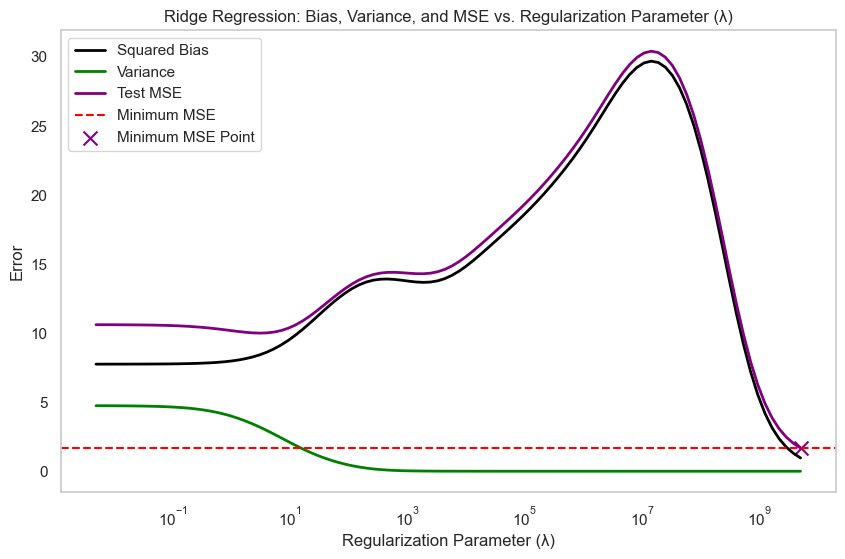

In [359]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, squared_bias, color='black', label='Squared Bias', linewidth=2)
plt.plot(alphas, variance, color='green', label='Variance', linewidth=2)
plt.plot(alphas, mse, color='purple', label='Test MSE', linewidth=2)
plt.xscale('log')
plt.axhline(y=min(mse), color='red', linestyle='--', label='Minimum MSE')
plt.scatter(alphas[np.argmin(mse)], min(mse), color='purple', marker='x', s=100, label='Minimum MSE Point')
plt.title('Ridge Regression: Bias, Variance, and MSE vs. Regularization Parameter (λ)')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

Instead of arbitrarily choosing alpha's, we use cross-validation to choose the tuning parameter alpha. We can do this using the cross-
validated ridge regression function, RidgeCV(). By default, the function performs generalized cross-validation (an efficient form of
LOOCV), though this can be changed using the argument cv. Once the RidgeCV finished, we will display the alpha value and use it in Ridge function to get the MSE, Score and see the coefficients values.

In [360]:
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import r2_score
 
# Use the Cross Validation to calculate the best alpha
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error') 
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

np.float64(12.38538177995857)

In [361]:
# Assuming X_train and X_test are DataFrames
ridge4 = Ridge(alpha=ridgecv.alpha_) 
ridge4.fit(X_train, y_train)
y_pred = ridge4.predict(X_test)

# Calculate and print MSE and R² Score
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.5f}")
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")
coefficients = ridge4.coef_

coef_series = pd.Series(ridge4.coef_, index=X.columns)
sorted_coef = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

print("Coefficients sorted by absolute value:")
print(sorted_coef)

Mean Squared Error: 0.13705
R² Score: 0.8103632648975432
Coefficients sorted by absolute value:
Altitude                             -0.467352
Soil_Type_Type_10                     0.158910
Soil_Type_Type_4                      0.152990
Soil_Type_Type_2                      0.131169
Soil_Type_Type_6                      0.115967
Soil_Type_Type_23                    -0.110860
Soil_Type_Type_22                    -0.096149
Soil_Type_Type_29                    -0.083412
Soil_Type_Type_11                     0.071308
Soil_Type_Type_33                    -0.069533
Soil_Type_Type_3                      0.068139
Shadow_Index_12h                      0.066589
Horizontal_Distance_To_Water          0.058300
Soil_Type_Type_24                    -0.056392
Soil_Type_Type_32                    -0.056293
Soil_Type_Type_31                    -0.048341
Soil_Type_Type_38                    -0.044471
Soil_Type_Type_1                      0.043065
Soil_Type_Type_30                    -0.039305
Soil_Type_T

# Lasso Regression


Lasso (Least Absolute Shrinkage and Selection Operator) is a type of linear regression that uses L1 regularization to prevent overfitting by penalizing the absolute size of regression coefficients.
- It adds a penalty equivalent to the sum of the absolute values of coefficients to the loss function
- Lasso shrinks some coefficients to exactly zero, effectively selecting a subset of features. This makes it a good choice when dealing with high-dimensional data or when some features are irrelevant
- By shrinking coefficients, Lasso reduces variance at the cost of introducing some bias, helping to improve generalization

In [362]:
from sklearn.linear_model import Lasso, LassoCV 
from sklearn.preprocessing import scale  
 
lasso = Lasso(max_iter = 10000) 
coefs = [] 


mse = []
squared_bias = []
variance = []
 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(scale(X_train), y_train) 
    coefs.append(lasso.coef_) 

    y_pred = lasso.predict(X_test)

     # Calculate MSE
    mse.append(np.mean((y_pred - y_test) ** 2))
    
    # Calculate bias and variance
    bias = np.mean(y_pred - y_test)
    squared_bias.append(bias ** 2)
    variance.append(np.var(y_pred))
     
np.shape(coefs)

(100, 55)

Text(0, 0.5, 'weights')

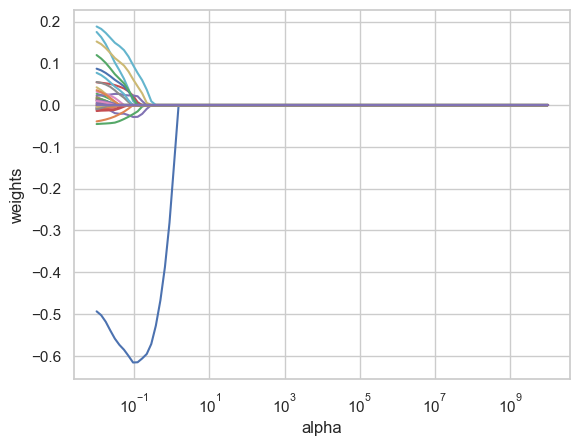

In [363]:
ax = plt.gca() 
ax.plot(alphas*2, coefs) 
ax.set_xscale('log') 
plt.axis('tight') 
plt.xlabel('alpha') 
plt.ylabel('weights')

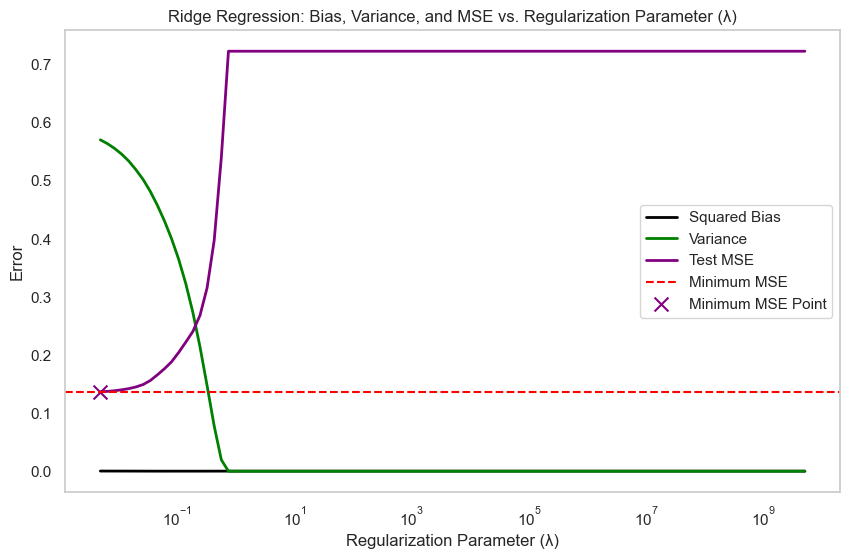

In [364]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, squared_bias, color='black', label='Squared Bias', linewidth=2)
plt.plot(alphas, variance, color='green', label='Variance', linewidth=2)
plt.plot(alphas, mse, color='purple', label='Test MSE', linewidth=2)
plt.xscale('log')
plt.axhline(y=min(mse), color='red', linestyle='--', label='Minimum MSE')
plt.scatter(alphas[np.argmin(mse)], min(mse), color='purple', marker='x', s=100, label='Minimum MSE Point')
plt.title('Ridge Regression: Bias, Variance, and MSE vs. Regularization Parameter (λ)')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()

In this section we are using the Cross Validation for selecting the best alpha value as it's critical part of the Regression. Once we have the alpha value we Train with Lasso using best alpha, predictions are made. After that we calculate the metrics as MSE and Score, and show the relevant results from model to see coefficients of different columns.

In [365]:
from sklearn.linear_model import Lasso, LassoCV
import numpy as np
import pandas as pd

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42).fit(X_train, y_train)

best_alpha = lasso_cv.alpha_
print(f"Best Alpha: {best_alpha}")

lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

coefficients = pd.Series(lasso.coef_, index=X.columns)
print("\nCoefficients (Feature Name: Value):")
print(coefficients)

features_to_drop = coefficients[coefficients == 0]

print("\nFeatures to Drop (Feature Name: Coefficient):")
for feature, coef in features_to_drop.items():
    print(f"{feature}: {coef}")



Best Alpha: 0.005
Mean Squared Error: 0.3699058840107219
R2 Score: 0.8106661506569797

Coefficients (Feature Name: Value):
Altitude                             -0.493776
Slope_Orientation                    -0.000000
Slope                                 0.027091
Horizontal_Distance_To_Water          0.054515
Vertical_Distance_To_Water            0.022735
Horizontal_Distance_To_Roadways       0.009953
Shadow_Index_9h                       0.032108
Shadow_Index_12h                      0.055382
Shadow_Index_15h                     -0.000000
Horizontal_Distance_To_Fire_Points   -0.000000
Canopy_Density                       -0.009231
Rainfall_Summer                      -0.002221
Rainfall_Winter                      -0.000000
Wind_Exposure_Level                   0.003393
Wilderness_Area_Area_1               -0.000000
Wilderness_Area_Area_2                0.019298
Wilderness_Area_Area_3                0.004736
Wilderness_Area_Area_4               -0.000000
Soil_Type_Type_1               